<a href="https://colab.research.google.com/github/Aliounegahn/Machine-Learning-Projects/blob/master/M2SID_TP2_GAHN_Alioune_Badara_Ba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M2 SID TP2 audio : Identification de Locuteurs

**NOM** : GAHN

**Prénom** : Alioune Badara Ba

**Email** : alioune-badara-ba.gahn@univ-tlse3.fr

---

L’objectifs de cette séance de TP AUDIO est d’utiliser une base donnée de voix locuteurs (avec le corpus audio-video VidTIMIT) et de réaliser une modélisation statistique des locuteurs. Pour celà vous allez créer un modèle de monde (UBM) et appliquer une adaptation de modèle (MLLR) pour adapter ce modèle aux locuteurs à reconnaître.

In [1]:
# OS setup
!cat /etc/os-release
!apt-get install -qq bc tree sox

!pip install python_speech_features

import os
import numpy as np
from scipy.io.wavfile import read
from sklearn import mixture
import python_speech_features as mfcc
from sklearn import preprocessing
import warnings
import pickle
from IPython.display import Audio
warnings.filterwarnings("ignore")
from sklearn.mixture import GaussianMixture
import pylab as pl
from scipy import linalg
import matplotlib as mpl
import itertools
import csv

# Liaison avec les données
!git clone https://gitlab.com/jeromefarinas/tp-m2-sid.git

NAME="Ubuntu"
VERSION="18.04.3 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.3 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic
Selecting previously unselected package libopencore-amrnb0:amd64.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../0-libopencore-amrnb0_0.1.3-2.1_amd64.deb ...
Unpacking libopencore-amrnb0:amd64 (0.1.3-2.1) ...
Selecting previously unselected package libopencore-amrwb0:amd64.
Preparing to unpack .../1-libopencore-amrwb0_0.1.3-2.1_amd64.deb ...
Unpacking libopencore-amrwb0:amd64 (0.1.3-2.1) ...
Selecting previously unselected package libmagic-mgc.
Preparing to unpack .../2-libmagic-mgc_1%3a5.32-2ubuntu0.2_amd64.deb ...
Unpacking libmagic-mgc (1:5.32-2ubuntu0.2)

In [2]:
# chemin vers données des locuteurs
chemin_corpus   = '/content/tp-m2-sid/corpus/locuteur/'
!tree $chemin_corpus

/content/tp-m2-sid/corpus/locuteur/
├── DATA
│   ├── fadg0
│   │   └── audio
│   │       ├── sa1.wav
│   │       ├── sa2.wav
│   │       ├── si1279.wav
│   │       ├── si1909.wav
│   │       ├── si649.wav
│   │       ├── sx109.wav
│   │       ├── sx199.wav
│   │       ├── sx19.wav
│   │       ├── sx289.wav
│   │       └── sx379.wav
│   ├── faks0
│   │   └── audio
│   │       ├── sa1.wav
│   │       ├── sa2.wav
│   │       ├── si1573.wav
│   │       ├── si2203.wav
│   │       ├── si943.wav
│   │       ├── sx133.wav
│   │       ├── sx223.wav
│   │       ├── sx313.wav
│   │       ├── sx403.wav
│   │       └── sx43.wav
│   ├── fcft0
│   │   └── audio
│   │       ├── sa1.wav
│   │       ├── sa2.wav
│   │       ├── si1178.wav
│   │       ├── si1808.wav
│   │       ├── si548.wav
│   │       ├── sx188.wav
│   │       ├── sx278.wav
│   │       ├── sx368.wav
│   │       ├── sx8.wav
│   │       └── sx98.wav
│   ├── fcmh0
│   │   └── audio
│   │       ├── sa1.wav
│   │       ├── sa2.wav
│   │     

Données :
1. 

In [3]:
!tree -L 1 /content/tp-m2-sid/corpus/

/content/tp-m2-sid/corpus/
├── development_set
├── locuteur
├── test_data
├── train_data
└── voyelles

5 directories, 0 files


## 1. Données

Les données à traiter sont issues du corpus audio-vidéo [VidTIMIT](https://conradsanderson.id.au/vidtimit/) créé par Conrad Sanderson dans le cadre de [sa thèse](http://conradsanderson.id.au/pdfs/sanderson_thesis_2003.pdf) sur la fusion d’informations audio et vidéo.

Le corpus est constitué à partir d’enregistremets de 43 personnes (24 hommes et 19 femmes) en 3 sessions espacés d’environ une semaine chacune.

La longueur moyenne de chaque fichier est de 4,25 secondes. Les enregistrements on été effectué dans un environnement de type bureau (milieu bruité).

Aperçu audio d'un locuteur :

In [43]:
fech,audio = read(chemin_corpus+'DATA/fcmh0/audio/sa1.wav')
Audio(audio, rate=fech)

##1. Paramétrisation

Vous utiliserez la fonction ci-dessous pour calculer des paramètres MFCC.

In [0]:
def get_MFCC(sr,audio):
    features = mfcc.mfcc(audio,sr, 0.025, 0.01, 13,appendEnergy = False)
    feat     = np.asarray(())
    for i in range(features.shape[0]):
        temp = features[i,:]
        if np.isnan(np.min(temp)):
            continue
        else:
            if feat.size == 0:
                feat = temp
            else:
                feat = np.vstack((feat, temp))
    features = feat;
    features = preprocessing.scale(features)
    return features

**A faire :**
1. **Affichez avec imshow la matrice MFCC correspondant à l'exemple audio écouté ci-dessus**
2. **A quoi sert la ligne features = preprocessing.scale(features) ?.**

1) affichons la matrice MFCC correspondante

In [0]:
matmfcc = get_MFCC(fech,audio)

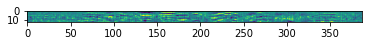

In [7]:
import matplotlib.pyplot as plt
plt.imshow(matmfcc.T)

2) la ligne features = preprocessing.scale(features) sert à normaliser nos données 

## 2. Création du modèle du monde (Universal Background Model)

Vous allez utiliser 35 locuteurs pour créer un fichier du monde avec la session 1 d’enregistrement. Vous utiliserez les fichiers contenu dans la liste liste ubm-train.lst pour réaliser l’apprentissage du GMM du monde (modèle du monde, Universal Background Model).
Utilisez la fonction GaussianMixture.fit de SciKitLearn pour effectuer l’apprentissage du mélange de lois normales par algorithme EM.

Choisissez 32 mélanges de gaussiennes et matrice de covariance diagonale.

Si vous avez des problèmes mémoire, vous pouvez restreindre le nombre de données à traiter en tirant aléatoirement les vecteurs sur votre ensemble.

In [0]:
def plot_gmm(gmm,X):
  color_iter = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])

  for i, (clf, title) in enumerate([(gmm, 'GMM')]):
    splot = pl.subplot(1, 1, 1 + i)
    Y_ = clf.predict(X)
    for i, (mean, covar, color) in enumerate(zip(
            clf.means_, clf.covariances_, color_iter)):
        v, w = linalg.eigh(np.diag(covar))
        #v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v) ###
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        pl.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        #angle = np.arctan(u[1] / u[0])
        #angle = 180 * angle / np.pi  # convert to degrees
        #ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
        #ell.set_clip_box(splot.bbox) ###
        #ell.set_alpha(0.5)
        #splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    #pl.xlim(-10, 10)
    #pl.ylim(-10, 10)
    pl.xticks(())
    pl.yticks(())
    pl.title(title)

  pl.show()


***A faire : ***
1. ***Utilisez la fonction affiche_gmm pour visualiser une représentation sur les deux premières dimensionsdes du modèle du monde.***
2. ***Affichez egalement deux histogrammes des données correspondant aux deux premières dimensions.***

In [9]:
# exemple de traitement de listes de fichiers pour générer la matrice des observations

X_train=np.empty([1,13]) 
List = open(chemin_corpus+"LISTS/ubm-train.lst")

for filename in List:
    # pour chaque fichier de l'apprentissage de l'UBM
    # 1. calcul des MFCC
    print(filename.rstrip())
    fech, audio = read(chemin_corpus + filename.rstrip())
    matriceMFCC = get_MFCC(fech, audio)
    print(np.shape(matriceMFCC))

    # concatenation dans une matrice qui contient tous les MFCC filtres
    X_train = np.vstack((X_train, matriceMFCC))
gmm = mixture.GaussianMixture(n_components = 32, max_iter = 200, covariance_type='diag', n_init = 3)
gmm.fit(X_train)
 
# enregistrement du modèle 
gmmfile = open( 'ubm' + '.gmm','wb')
pickle.dump(gmm,gmmfile)
print('enregistrement terminé pour ubm.gmm')





DATA/fcmr0/audio/sa1.wav
(423, 13)
DATA/fcmr0/audio/sa2.wav
(399, 13)
DATA/fcmr0/audio/si1105.wav
(475, 13)
DATA/fcmr0/audio/si1735.wav
(311, 13)
DATA/fcmr0/audio/si475.wav
(299, 13)
DATA/fcrh0/audio/sa1.wav
(479, 13)
DATA/fcrh0/audio/sa2.wav
(395, 13)
DATA/fcrh0/audio/si1088.wav
(415, 13)
DATA/fcrh0/audio/si1718.wav
(299, 13)
DATA/fcrh0/audio/si458.wav
(391, 13)
DATA/fdac1/audio/sa1.wav
(379, 13)
DATA/fdac1/audio/sa2.wav
(303, 13)
DATA/fdac1/audio/si1474.wav
(351, 13)
DATA/fdac1/audio/si2104.wav
(383, 13)
DATA/fdac1/audio/si844.wav
(547, 13)
DATA/fdms0/audio/sa1.wav
(459, 13)
DATA/fdms0/audio/sa2.wav
(431, 13)
DATA/fdms0/audio/si1218.wav
(371, 13)
DATA/fdms0/audio/si1502.wav
(519, 13)
DATA/fdms0/audio/si1848.wav
(387, 13)
DATA/fdrd1/audio/sa1.wav
(543, 13)
DATA/fdrd1/audio/sa2.wav
(411, 13)
DATA/fdrd1/audio/si1544.wav
(347, 13)
DATA/fdrd1/audio/si1566.wav
(571, 13)
DATA/fdrd1/audio/si2149.wav
(607, 13)
DATA/fedw0/audio/sa1.wav
(367, 13)
DATA/fedw0/audio/sa2.wav
(347, 13)
DATA/fedw0/au

Affichons le modèle

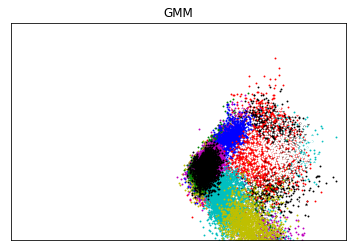

In [10]:
plot_gmm(gmm,X_train)

## 3. Adaptation aux locuteurs

Il s’agit maintenant d’adapter le modèle du monde aux locuteurs cibles. Deux techniques sont disponibles : MAP et MLLR. Les listes locuteurX-train.lst contiennent la listes des fichiers nécessaire pour adapter au locuteur X (session 1, locuteur non utilisée dans l’UBM).

In [0]:
def gmm_mllr_diag_cov(X, gmm, niter=10):
  """ 
     GMM adaptation (only means) using MLLR for GMM with diagonal covariance matrix.

     Usage: gmm_mllr_diag_cov(X, gmm, niter)
     
     References: Leggetter & Woodland'1995
     
     From: Kevin Hu https://github.com/mrhuke/GMM-adaptation
  """

  # remove illed gaussians
  logprob=gmm.score_samples(X)
  pcompx=gmm.predict_proba(X)
  ###logprob,pcompx = gmm.eval(X)
  psum = np.sum(pcompx, axis=0)
  ill_g = (psum == 0);
  if any(ill_g):
    valid = psum > 0
    gmm.means_ = gmm.means_[valid,:]
    gmm.weights_ = gmm.weights_[valid]
    gmm.weights_ = gmm.weights_/sum(gmm.weights_)
    gmm.covariances_ = gmm.covariances_[valid]
    ###logprob,pcompx = gmm.eval(X)
    logprob=gmm.score_samples(X)
    pcompx=gmm.predict_proba(X)

  # calculate G and Z 
  C = len(gmm.weights_)
  T,dim = X.shape
  W = np.empty([dim,dim+1])
  G = np.zeros([dim,dim+1,dim+1])
  # 1. first calculate D[0,...,C) and Z
  D = np.zeros([C,dim+1,dim+1])
  V = np.zeros([C,dim,dim])
  Z = np.zeros([dim,dim+1])
  for c in range(0,C):
    mu = gmm.means_[c]
    sigma = np.diag(gmm.covariances_[c])
    sigma_inv = np.linalg.inv(sigma)
    p = pcompx[:,c]

    xi = np.empty_like(mu)
    xi[:] = mu
    xi = np.insert(xi,0,1)
    xi = np.reshape(xi, [len(xi),1])
    D[c] = xi.dot(xi.T)
    V[c] = np.sum(p)*sigma_inv
    for t in range(0,T):
      xt = np.reshape(X[t],[len(X[t]),1])
      Z += p[t]*sigma_inv.dot(xt).dot(xi.T)
    
  # 2. now calculate G
  for i in range(0,dim): 
    for c in range(0,C): # tie all Gaussians
      G[i] += V[c,i,i]*D[c]
    try: 
      G_i_inv = np.linalg.inv(G[i])
    except:
      print ('G is nearly singular and pseudo-inverse is used.')
      G_i_inv = np.linalg.pinv(G[i])
    z_i = np.reshape(Z[i],[dim+1,1])
    W[i] = G_i_inv.dot(z_i)[:,0]
  
  # transform means
  for c in range(0,C):
    xi = np.insert(gmm.means_[c],0,1)
    xi = np.reshape(xi,[len(xi),1])
    gmm.means_[c] = W.dot(xi)[:,0]
      
  # remove non positive definite matrices
  ###logprob,pcompx = gmm.eval(X)
  logprob=gmm.score_samples(X)
  pcompx=gmm.predict_proba(X)
  psum = np.sum(pcompx, axis=0)
  ill = (psum == 0);
  if np.any(ill):
    valid = (ill == 0)
    gmm.means_ = gmm.means_[valid]
    gmm.weights_ = gmm.weights_[valid]
    gmm.weights_ = gmm.weights_/sum(gmm.weights_)
    gmm.covariances_ = gmm.covariances_[valid]
    K = gmm.means_.shape[0]
  return gmm


***Questions :***
1. ***Utilisez la fonction gmm_mllr_diag_cov pour effectuer l’adaptation MLLR à chacun des 6 locuteurs en utilisant les fichiers locuteurX-train.lst.
Affichez les paramètres obtenus par MLLR avec la fonction affiche_gmm.***
2. ***Si on avait fait une adaptation par MAP, quelle aurait été la différence par rapport à MLLR ?***

1) Effectuons l'adaptation MLLR et affichons les parametres obtenus par MLLR

In [0]:
# Fonction permettant de creer les vecteurs xtrain 
def getx (i):
    X_train=np.empty([1,13]) 
    List = open(chemin_corpus+"LISTS/locuteur"+str(i)+"-train.lst")

    for filename in List:
        # pour chaque fichier de l'apprentissage de l'UBM
        # 1. calcul des MFCC
        print(filename.rstrip())
        fech, audio = read(chemin_corpus + filename.rstrip())
        matriceMFCC = get_MFCC(fech, audio)
        print(np.shape(matriceMFCC))

        # concatenation dans une matrice qui contient tous les MFCC filtres
        X_train = np.vstack((X_train, matriceMFCC))
    return (X_train)
      

In [13]:
listx =[]
for i in [1,2,3,4,5,6]:
  listx.append(getx(i))

DATA/fadg0/audio/sx109.wav
(539, 13)
DATA/fadg0/audio/sx19.wav
(387, 13)
DATA/fadg0/audio/sx199.wav
(575, 13)
DATA/fadg0/audio/sx289.wav
(503, 13)
DATA/fadg0/audio/sx379.wav
(435, 13)
DATA/faks0/audio/sx133.wav
(387, 13)
DATA/faks0/audio/sx223.wav
(355, 13)
DATA/faks0/audio/sx313.wav
(359, 13)
DATA/faks0/audio/sx403.wav
(387, 13)
DATA/faks0/audio/sx43.wav
(343, 13)
DATA/fcft0/audio/sx188.wav
(411, 13)
DATA/fcft0/audio/sx278.wav
(547, 13)
DATA/fcft0/audio/sx368.wav
(487, 13)
DATA/fcft0/audio/sx8.wav
(403, 13)
DATA/fcft0/audio/sx98.wav
(283, 13)
DATA/fcmh0/audio/sx104.wav
(283, 13)
DATA/fcmh0/audio/sx14.wav
(395, 13)
DATA/fcmh0/audio/sx194.wav
(275, 13)
DATA/fcmh0/audio/sx284.wav
(503, 13)
DATA/fcmh0/audio/sx374.wav
(311, 13)
DATA/mstk0/audio/sx124.wav
(223, 13)
DATA/mstk0/audio/sx214.wav
(367, 13)
DATA/mstk0/audio/sx304.wav
(375, 13)
DATA/mstk0/audio/sx34.wav
(295, 13)
DATA/mstk0/audio/sx394.wav
(327, 13)
DATA/mtas1/audio/sx118.wav
(323, 13)
DATA/mtas1/audio/sx208.wav
(403, 13)
DATA/mta

In [0]:
listgmm = []
for j in listx:
  listgmm.append(gmm_mllr_diag_cov(j, gmm, niter=10))

In [15]:
listgmm

[GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=200,
                 means_init=None, n_components=32, n_init=3,
                 precisions_init=None, random_state=None, reg_covar=1e-06,
                 tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                 weights_init=None),
 GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=200,
                 means_init=None, n_components=32, n_init=3,
                 precisions_init=None, random_state=None, reg_covar=1e-06,
                 tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                 weights_init=None),
 GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=200,
                 means_init=None, n_components=32, n_init=3,
                 precisions_init=None, random_state=None, reg_covar=1e-06,
                 tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                 weights_init=None),
 GaussianMixture

Affichons les parametres des gmmi obtenus 

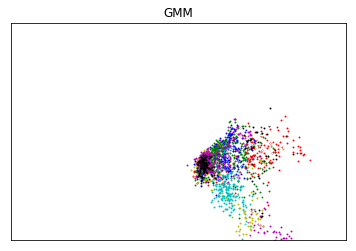

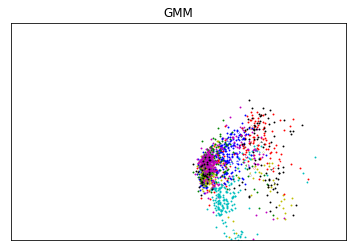

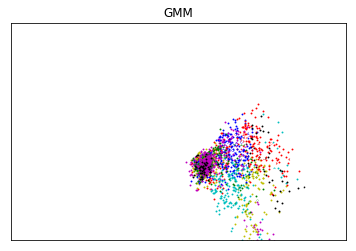

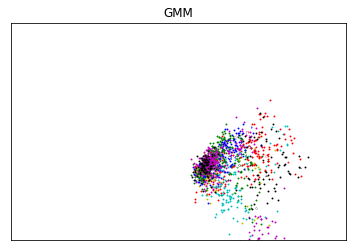

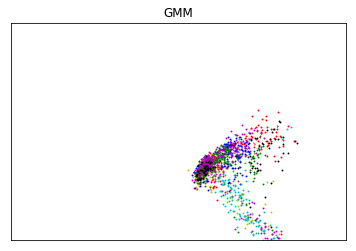

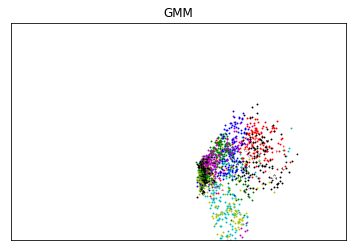

[None, None, None, None, None, None]

In [16]:
[plot_gmm(listgmm[i],listx[i]) for i in [0,1,2,3,4,5]]

On observe qu'on a pas les memes distribution de gaussiennes visuellement.

2) La difference entre la MAP et MLRR est que la méthode MLRR ne prend en compte que les moyennes tandis que les map prennent aussi en compte les matrices de covariances ainsi que les poids associés aux gaussiennes en sus de la moyenne. Elle marcherait moins bon ici car on a un petit set de données

## 4. Evaluation du système
1. ***Testez locuteur par locuteur les deux méthodes MLLR et MAP en utilisant en test les fichiers de la session 2 et 3 (liste locuteurX-test.lst pour les fichiers de test du locuteur X). Les phrases prononcées sont différentes des phrases de la session 1 utilisée pour l’apprentissage. Calculez un taux de reconnaissance.***
2. ***Comparez les résultats sur le meilleur système en activant ou désactivant la normalisation des paramètres MFCC. Qu'en pensez-vous ?***

In [0]:
# Fonction permettant de creer un vecteur xtest pour chaque fichier locuteur comme on a construit les xtrain
def gettestx (i):
    X_train=np.empty([1,13]) 
    List = open(chemin_corpus+"LISTS/locuteur"+str(i)+"-test.lst")

    for filename in List:
        # pour chaque fichier de l'apprentissage de l'UBM
        # 1. calcul des MFCC
        print(filename.rstrip())
        fech, audio = read(chemin_corpus + filename.rstrip())
        matriceMFCC = get_MFCC(fech, audio)
        print(np.shape(matriceMFCC))

        # concatenation dans une matrice qui contient tous les MFCC filtres
        X_train = np.vstack((X_train, matriceMFCC))
    return (X_train)
      

In [18]:
listtestx =[]
for i in [1,2,3,4,5,6]:
  listtestx.append(gettestx(i))

DATA/fadg0/audio/sa1.wav
(475, 13)
DATA/fadg0/audio/sa2.wav
(411, 13)
DATA/fadg0/audio/si1279.wav
(287, 13)
DATA/fadg0/audio/si1909.wav
(467, 13)
DATA/fadg0/audio/si649.wav
(863, 13)
DATA/faks0/audio/sa1.wav
(355, 13)
DATA/faks0/audio/sa2.wav
(323, 13)
DATA/faks0/audio/si1573.wav
(579, 13)
DATA/faks0/audio/si2203.wav
(323, 13)
DATA/faks0/audio/si943.wav
(391, 13)
DATA/fcft0/audio/sa1.wav
(403, 13)
DATA/fcft0/audio/sa2.wav
(331, 13)
DATA/fcft0/audio/si1178.wav
(543, 13)
DATA/fcft0/audio/si1808.wav
(447, 13)
DATA/fcft0/audio/si548.wav
(247, 13)
DATA/fcmh0/audio/sa1.wav
(387, 13)
DATA/fcmh0/audio/sa2.wav
(391, 13)
DATA/fcmh0/audio/si1454.wav
(507, 13)
DATA/fcmh0/audio/si2084.wav
(303, 13)
DATA/fcmh0/audio/si824.wav
(555, 13)
DATA/mstk0/audio/sa1.wav
(371, 13)
DATA/mstk0/audio/sa2.wav
(347, 13)
DATA/mstk0/audio/si1024.wav
(599, 13)
DATA/mstk0/audio/si2222.wav
(431, 13)
DATA/mstk0/audio/si2284.wav
(275, 13)
DATA/mtas1/audio/sa1.wav
(491, 13)
DATA/mtas1/audio/sa2.wav
(379, 13)
DATA/mtas1/aud

Pour évaluer notre modèle. Nous allons parcourir le vecteur de prediction obtenu en utilisant chaque modèle gmm pour chaque fichier wav dans chaque fichier locuteur test. En ensuite prendre le locuteur qui le score maximal par composante du vecteur de prediction. Nous nous retrouverons donc avec un vecteur composé du numéro de locuteur prédit pour chaque composante puis nous choisissons le locuteur le plus présent en procedant par vote.

In [48]:
vl = 0 
fl = 0

models    = listgmm
List = open(chemin_corpus+"LISTS/locuteur3-test.lst")
for filename in List:
    # pour chaque fichier de l'apprentissage de l'UBM
    # 1. calcul des MFCC
    print(filename.rstrip())
    fech, audio = read(chemin_corpus + filename.rstrip())
    features = get_MFCC(fech, audio)
    scores     = None
    listres = []
    for i in range(len(models)):
        gmm    = models[i]         #passage en revue des modeles un par un
        scores = np.array(gmm.score_samples(features))
        listres.append(scores)
    j = []
    for i in range (len(listres[0])):
      j.append(np.argmax([k[i] for k in listres ]))
    s = [j.count(i) for i in np.unique(j)]
    winner = j[np.argmax(s)] + 1
    if winner == 1:
      vl = vl + 1
    else:
      fl = fl + 1
    print("\tdétecté comme - ", winner,"\n")

DATA/fcft0/audio/sa1.wav
	détecté comme -  1 

DATA/fcft0/audio/sa2.wav
	détecté comme -  1 

DATA/fcft0/audio/si1178.wav
	détecté comme -  1 

DATA/fcft0/audio/si1808.wav
	détecté comme -  1 

DATA/fcft0/audio/si548.wav
	détecté comme -  1 



Nous remarquons que cette méthode ne nous permets pas d'évaluer nos modèles car la fonction score_samples() renvoie le meme vecteur pour chaque fichier wav en utilisant les différents modèles gaussian mixture.  
Ceci ne nous permets donc pas d'évaluer notre modèle.
Ceci n'a pas marché car nous stockons auparavant les modèles gmm et en les relisant ca ne marche pas. Pour résoudre cela nous allons creer les gmm dans la meme boucle on l'on évalue les modeles.

In [63]:
vl = 0 
fl = 0
for o in [1,2,3,4,5,6]:
  List = open(chemin_corpus+"LISTS/locuteur"+str(o)+"-test.lst")
  for filename in List:
      # pour chaque fichier de l'apprentissage de l'UBM
      # 1. calcul des MFCC
      print(filename.rstrip())
      fech, audio = read(chemin_corpus + filename.rstrip())
      features = get_MFCC(fech, audio)
      scores     = None
      listres = []
      for i,j in enumerate(listx):
          gmm    = gmm_mllr_diag_cov(j, gmm, niter=10)       #passage en revue des modeles un par un
          scores = np.array(gmm.score_samples(features))
          listres.append(scores)
      j = []
      # determination du locuteur predit pour chaque composante des vecteurs de predictions 
      for i in range (len(listres[0])):    
        j.append(np.argmax([k[i] for k in listres ]))
      s = [j.count(i) for i in np.unique(j)] # determination du locuteur par vote
      winner = j[np.argmax(s)] + 1
      if winner == o:
        vl = vl + 1 # bonne prediction
      else:
        fl = fl + 1 # mauvaise prediction
      print("\t Locuteur",o,"\tdétecté comme - ", winner,"\n")

DATA/fadg0/audio/sa1.wav
	 Locuteur 1 	détecté comme -  1 

DATA/fadg0/audio/sa2.wav
	 Locuteur 1 	détecté comme -  4 

DATA/fadg0/audio/si1279.wav
	 Locuteur 1 	détecté comme -  4 

DATA/fadg0/audio/si1909.wav
	 Locuteur 1 	détecté comme -  3 

DATA/fadg0/audio/si649.wav
	 Locuteur 1 	détecté comme -  3 

DATA/faks0/audio/sa1.wav
	 Locuteur 2 	détecté comme -  3 

DATA/faks0/audio/sa2.wav
	 Locuteur 2 	détecté comme -  4 

DATA/faks0/audio/si1573.wav
	 Locuteur 2 	détecté comme -  1 

DATA/faks0/audio/si2203.wav
	 Locuteur 2 	détecté comme -  4 

DATA/faks0/audio/si943.wav
	 Locuteur 2 	détecté comme -  3 

DATA/fcft0/audio/sa1.wav
	 Locuteur 3 	détecté comme -  3 

DATA/fcft0/audio/sa2.wav
	 Locuteur 3 	détecté comme -  3 

DATA/fcft0/audio/si1178.wav
	 Locuteur 3 	détecté comme -  3 

DATA/fcft0/audio/si1808.wav
	 Locuteur 3 	détecté comme -  4 

DATA/fcft0/audio/si548.wav
	 Locuteur 3 	détecté comme -  6 

DATA/fcmh0/audio/sa1.wav
	 Locuteur 4 	détecté comme -  2 

DATA/fcmh0/audio

In [0]:
### l'accuracy du modèle vaut:
acc = vl / (vl + fl)

In [65]:
acc

0.43333333333333335

Nous avons une accuracy de 43% selon cette méthode d'évaluation

Une seconde facon d'évaluer nos modèles est de parcourir chaque fichier wav de chaque liste test de locuteurs et pour chaque gmm nous enregistrons la somme des composantes du vecteur predit et ensuite nous choisissons comme locuteur produit celui dont le gmm associé maximise cette somme des composantes du vecteur obtenu avec la fonction score_samples() (aulieu de determiner l'argmax par composante et voter comme fait précedemment). 
Ceci reviendrait à utiliser la meme méthode d'évaluation utilisée au TP1. Le code suivant nous permet de réaliser cela: 

In [68]:
vl = 0 
fl = 0
for o in [1,2,3,4,5,6]:
  List = open(chemin_corpus+"LISTS/locuteur"+str(o)+"-test.lst")
  for filename in List:
      # pour chaque fichier de l'apprentissage de l'UBM
      # 1. calcul des MFCC
      print(filename.rstrip())
      fech, audio = read(chemin_corpus + filename.rstrip())
      features = get_MFCC(fech, audio)
      scores     = None
      listres = []
      for i,j in enumerate(listx):
          gmm    = gmm_mllr_diag_cov(j, gmm, niter=10)       #passage en revue des modeles un par un
          scores = np.array(gmm.score_samples(features))
          listres.append(scores.sum())
      # determination du locuteur predit pour chaque composante des vecteurs de predictions 
      winner = np.argmax(listres) + 1
      if winner == o:
        vl = vl + 1 # bonne prediction
      else:
        fl = fl + 1 # mauvaise prediction
      print("\t Locuteur",o,"\tdétecté comme - ", winner,"\n")

DATA/fadg0/audio/sa1.wav
	 Locuteur 1 	détecté comme -  1 

DATA/fadg0/audio/sa2.wav
	 Locuteur 1 	détecté comme -  1 

DATA/fadg0/audio/si1279.wav
	 Locuteur 1 	détecté comme -  1 

DATA/fadg0/audio/si1909.wav
	 Locuteur 1 	détecté comme -  1 

DATA/fadg0/audio/si649.wav
	 Locuteur 1 	détecté comme -  1 

DATA/faks0/audio/sa1.wav
	 Locuteur 2 	détecté comme -  2 

DATA/faks0/audio/sa2.wav
	 Locuteur 2 	détecté comme -  2 

DATA/faks0/audio/si1573.wav
	 Locuteur 2 	détecté comme -  4 

DATA/faks0/audio/si2203.wav
	 Locuteur 2 	détecté comme -  2 

DATA/faks0/audio/si943.wav
	 Locuteur 2 	détecté comme -  2 

DATA/fcft0/audio/sa1.wav
	 Locuteur 3 	détecté comme -  3 

DATA/fcft0/audio/sa2.wav
	 Locuteur 3 	détecté comme -  3 

DATA/fcft0/audio/si1178.wav
	 Locuteur 3 	détecté comme -  3 

DATA/fcft0/audio/si1808.wav
	 Locuteur 3 	détecté comme -  3 

DATA/fcft0/audio/si548.wav
	 Locuteur 3 	détecté comme -  4 

DATA/fcmh0/audio/sa1.wav
	 Locuteur 4 	détecté comme -  4 

DATA/fcmh0/audio

In [0]:
### l'accuracy du modèle vaut:
acc = vl / (vl + fl)

In [70]:
acc

0.9

Cette méthode d'évaluation nous donne une accuracy de 90%

Une autre facon d'évaluer le modèle consiste à construire un seul vecteur pour chaque fichier locuteur (comme on a construit les vecteurs d'entrainement des gmm)aulieu de parcourir tous les fichiers wav de chaque locuteur.
Ainsi pour chaque fichier test locuteur nous évaluons le modèle en choisissant celui qui maximise le score de prediction. 

L'interet de cette méthode est qu'elle nous donne une information plus globale sur la qualité de prediction en fonction du locuteur. elle nous permets de donner une interpretation plus generale en fonction des locuteurs

In [72]:
#### Méthode avec constructions des xtest comme lors de la phase d'entrainement
vl = 0 
fl = 0
List = listtestx
for i,filename in enumerate(List):
    log_likelihood = []
    for j in (listx):
        gmm    = gmm_mllr_diag_cov(j, gmm, niter=10)       #passage en revue des modeles un par un
        scores = np.array(gmm.score(filename))
        log_likelihood.append(scores)
    winner = np.argmax(log_likelihood) + 1
    if winner == i+1:
      vl = vl + 1
    else:
      fl = fl + 1
    print("\tlocuteur", i+1,"\tdétecté comme - ", winner,"\n")

	locuteur 1 	détecté comme -  1 

	locuteur 2 	détecté comme -  2 

	locuteur 3 	détecté comme -  3 

	locuteur 4 	détecté comme -  4 

	locuteur 5 	détecté comme -  5 

	locuteur 6 	détecté comme -  6 



In [0]:
### l'accuracy du modèle vaut:
acc = vl / (vl + fl)

In [74]:
acc

1.0

Cette derniere méthode nous donne une accuracy de 1. 
L'interpretation que nous pouvons en faire qu'en général notre modèle classifie bien les locuteurs. Il se trompe peut etre parfois mais generalement ca marche bien. 

Ce qui est confirmé par notre deuxieme méthode d'évaluation car nous voyons qu'on se trompe une fois seulement sur 5 à chaque fois sur les enregistrements des locuteurs (2,3,4) et 0 fois sur le reste. 

On peut donc dire que globalement notre modèle classifie bien les différents locuteurs